This notebook provides an overview of the use of self-organizing maps (SOMs) in cheminformatics.

To start, we need to import a bunch of libraries.  Most of these should be included if you've installed the RDKit.  The only libraries you should need to install are [minisom](https://github.com/JustGlowing/minisom) for the SOM and [tqdm](https://github.com/tqdm/tqdm) for progress bars.
```
pip install minisom tqdm
```

In [1]:
!pip install minisom

  Created wheel for minisom: filename=MiniSom-2.2.1-cp37-none-any.whl size=6645 sha256=f917d62f93af6d9e7d1f3692be181f5976db1e540d4b6b110beebfc4c0014ab8
  Stored in directory: /home/ubuntu/.cache/pip/wheels/41/42/7d/dd12b479c5ea50cd572d91b8e935e4f11e1302acca329f84e0
Successfully built minisom


In [1]:
from collections import Counter
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys, Draw
from rdkit import DataStructs
import numpy as np
from tqdm import tqdm
from minisom import MiniSom
import sys
from time import time
import math

Enable matplotlib plots in the this notebook

In [2]:
%matplotlib inline

A few functions to generate fingerprints. The first function generates 166-bit MACCS keys.  The second generates Morgan fingerprints.  While both will work for building a SOM, the process will be a bit faster with MACCS keys. I tend to like MACCS keys for generating SOMs.  These fingerprints typically do a good job of grouping a set of molecules by scaffold. The third function takes a list of SMILES as input and returns as a list of fingerprints. If this function is called with one argument, it generates MACCS keys.  We can also pass a function as a second argument to generate a different fingerprint type.  For instance, we could call it like this to generate Morgan fingerprints.  
```
generate_fps(my_smiles_list,morgan_as_np)
```

In [3]:
def maccs_as_np(mol):
    """
    Generate MACCS fingerprints as a NumPy array
    :param mol: input molecule
    :return: fingerprint as a NumPy array
    """
    bv = MACCSkeys.GenMACCSKeys(mol)
    return np.array([int(x) for x in list(bv.ToBitString())], dtype=np.float32)


def morgan_as_np(mol):
    """
    Generate a 1024 bit Morgan fingerprint as a NumPy array
    :param mol: input molecule
    :return: fingerprint as a NumPy array
    """
    bv = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=1024)
    arr = np.zeros((1,), dtype=np.float32)
    DataStructs.ConvertToNumpyArray(bv, arr)
    return arr


def generate_fps(smiles_list, fp_function=maccs_as_np):
    """
    Take a list of SMILES as input and return a list of NumPy arrays
    :param smiles_list: list of SMILES
    :param fp_function: function to calculate fingerprints
    :return: list of NumPy arrays containing fingerprints
    """
    output_fp_list = []
    for smiles in tqdm(smiles_list, desc="Generating Fingerprints"):
        output_fp_list.append(fp_function(Chem.MolFromSmiles(smiles)))
    return output_fp_list

A function to generate a grid of pie charts showing the distribution of active and inactive compounds in each grid cell. 

In [4]:
# Adapted from the MiniSom example notebook
def depict_som(cluster_df, x_dim, y_dim, x_column="X", y_column="Y"):
    """
    Draw a SOM with each cell depicted as a pie chart
    :param cluster_df: data frame with SOM output, should have columns active, X, and Y
    :param x_dim: X dimension of the SOM
    :param y_dim: Y dimension of the SOM
    :return:
    """
    required_colums = [x_column, y_column, "active"]
    for col in required_colums:
        if col not in cluster_df.columns:
            print(f"Error {col} not in dataframe columns", file=sys.stderr)
            sys.exit(1)
    cell_dict = {}
    for k, v in [x for x in cluster_df.groupby([x_column, y_column])]:
        cell_dict[k] = Counter(v["active"])
        cell_names = cluster_df["active"].unique()
    plt.figure(figsize=(x_dim, y_dim))
    the_grid = GridSpec(x_dim, y_dim)
    for position in cell_dict.keys():
        label_fracs = [cell_dict[position][l] for l in cell_names]
        plt.subplot(the_grid[(x_dim - 1) - position[1], position[0]], aspect=1)
        patches, texts = plt.pie(label_fracs)

Build a SOM with minisom

In [6]:
def build_minisom_som(fp_list_in, x_dim=10, y_dim=10, num_iters=20000):
    """
    Build a SOM with MiniSom
    :param fp_list_in: input list of fingerprints as NumPy arrays
    :param x_dim: X dimension of the SOM
    :param y_dim: Y dimension of the SOM
    :param num_iters: number of iterations when building the SOM
    :return: lists with X and Y coordinates in the SOM
    """
    print("Training SOM")
    start_time = time()
    som = MiniSom(x_dim, y_dim, len(fp_list_in[0]), sigma=0.3, learning_rate=0.5, random_seed=1)
    som.train_random(fp_list_in, num_iters)
    x = []
    y = []
    # find best matching units
    print("Finding BMUs")
    for row in fp_list_in:
        x_val, y_val = som.winner(row)
        x.append(x_val)
        y.append(y_val)
    elapsed_time = time()-start_time
    print("Done\nElapsed time = %.2f sec" % elapsed_time)
    return x, y

Now that we have the necessary functions in place, we can have some fun.  We will read in a csv file containing SMILES, a molecule name, and 1 or 0 indicating that the molecule is active into a Pandas data frame. The first few lines of the file look like this.
```
SMILES,Name,active
Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCCN5CCOCC5)OC,168691,1
C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2c7ccccc7c6c8c5C(=O)NC8)NC)OC,86358,1
Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3)Cl)Nc4cccc5c4OC(O5)(F)F,575087,1
Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3)Cl)Nc4cccc5c4OCO5,575065,1
```
We then use the function generate_fps to generate a list of fingerprints from the SMILES column in the dataframe. This list of fingerprints is then used to generate X and Y coordinates for each molecule in the grid.  The x and y coordinates generated by build_minisom_som are then added as columns to the original dataframe.  This dataframe, as well as the grid dimensions, are then passed to the depiction function to generate the plot below. 

Generating Fingerprints: 100%|██████████| 4629/4629 [00:10<00:00, 429.37it/s]


Training SOM
Finding BMUs
Done
Elapsed time = 19.60 sec


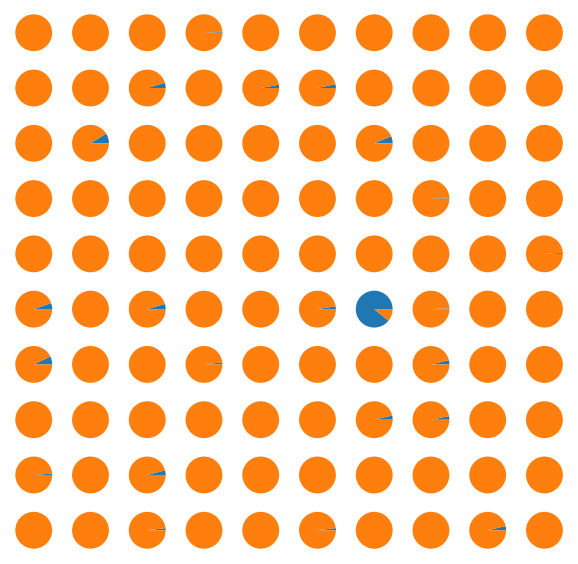

In [8]:
# read the input file into a dataframe
act_df = pd.read_csv("../data/dude_erk2_mk01.csv")
cols = list(act_df.columns)
cols[2] = "active"
act_df.columns = cols
# generate fingerprints
fp_list = generate_fps(act_df.SMILES)
# build the SOM
x_dim = 10
y_dim = 10
som_x, som_y = build_minisom_som(fp_list, x_dim, y_dim)
# set dataframe columns to SOM output
act_df["X"] = som_x
act_df["Y"] = som_y
# Draw the SOM
depict_som(act_df, x_dim, y_dim)

The dataset we used above is the [ERK2 (aka MK01)](http://dude.docking.org/targets/mk01) dataset that is part of the [DUD-E dataset](http://dude.docking.org/), which was designed for the evaluation of docking programs.  The DUDE-E database consists of sets of active compounds, curated from the literature, and decoy compounds with similar calculated properties (molecular weight, LogP).  The compound sets in the database were designed to evaluate the ability of a docking program to distinguish active compounds from decoys.  

In the plot above the active compounds are shown in blue, while the decoy compounds are shown in orange.  As we can see, our fingerprints do a reasonably good job of separating the active compounds from the decoys.  In particular, we see that one cell at position 6,4 (we start counting from 0) is highly enriched in active compounds.  Let's take a closer look at molecules in that cell.  

We can use the Pandas query function to create a new dataframe containing only the molecules at position 6,4

In [9]:
my_cell = act_df.query("X==6 and Y==4")

To make it easier to visualize the molecules in cell 6,4 we will sort the SMILES so that the active molecules are first, followed by the decoy molecules. 

In [10]:
my_smiles_list = [x[1] for x in sorted(zip(my_cell.active,my_cell.SMILES),reverse=True)]

Active and decoy are currently indicated by 1 and 0 in the dataframe.  To have better labels, we will convert 1 and 0 to the strings "active" and decoy. 

In [11]:
my_active_list = [x[0] for x in sorted(zip(my_cell.active,my_cell.SMILES),reverse=True)]
active_label_list = ["active" if a else "decoy" for a in my_active_list]

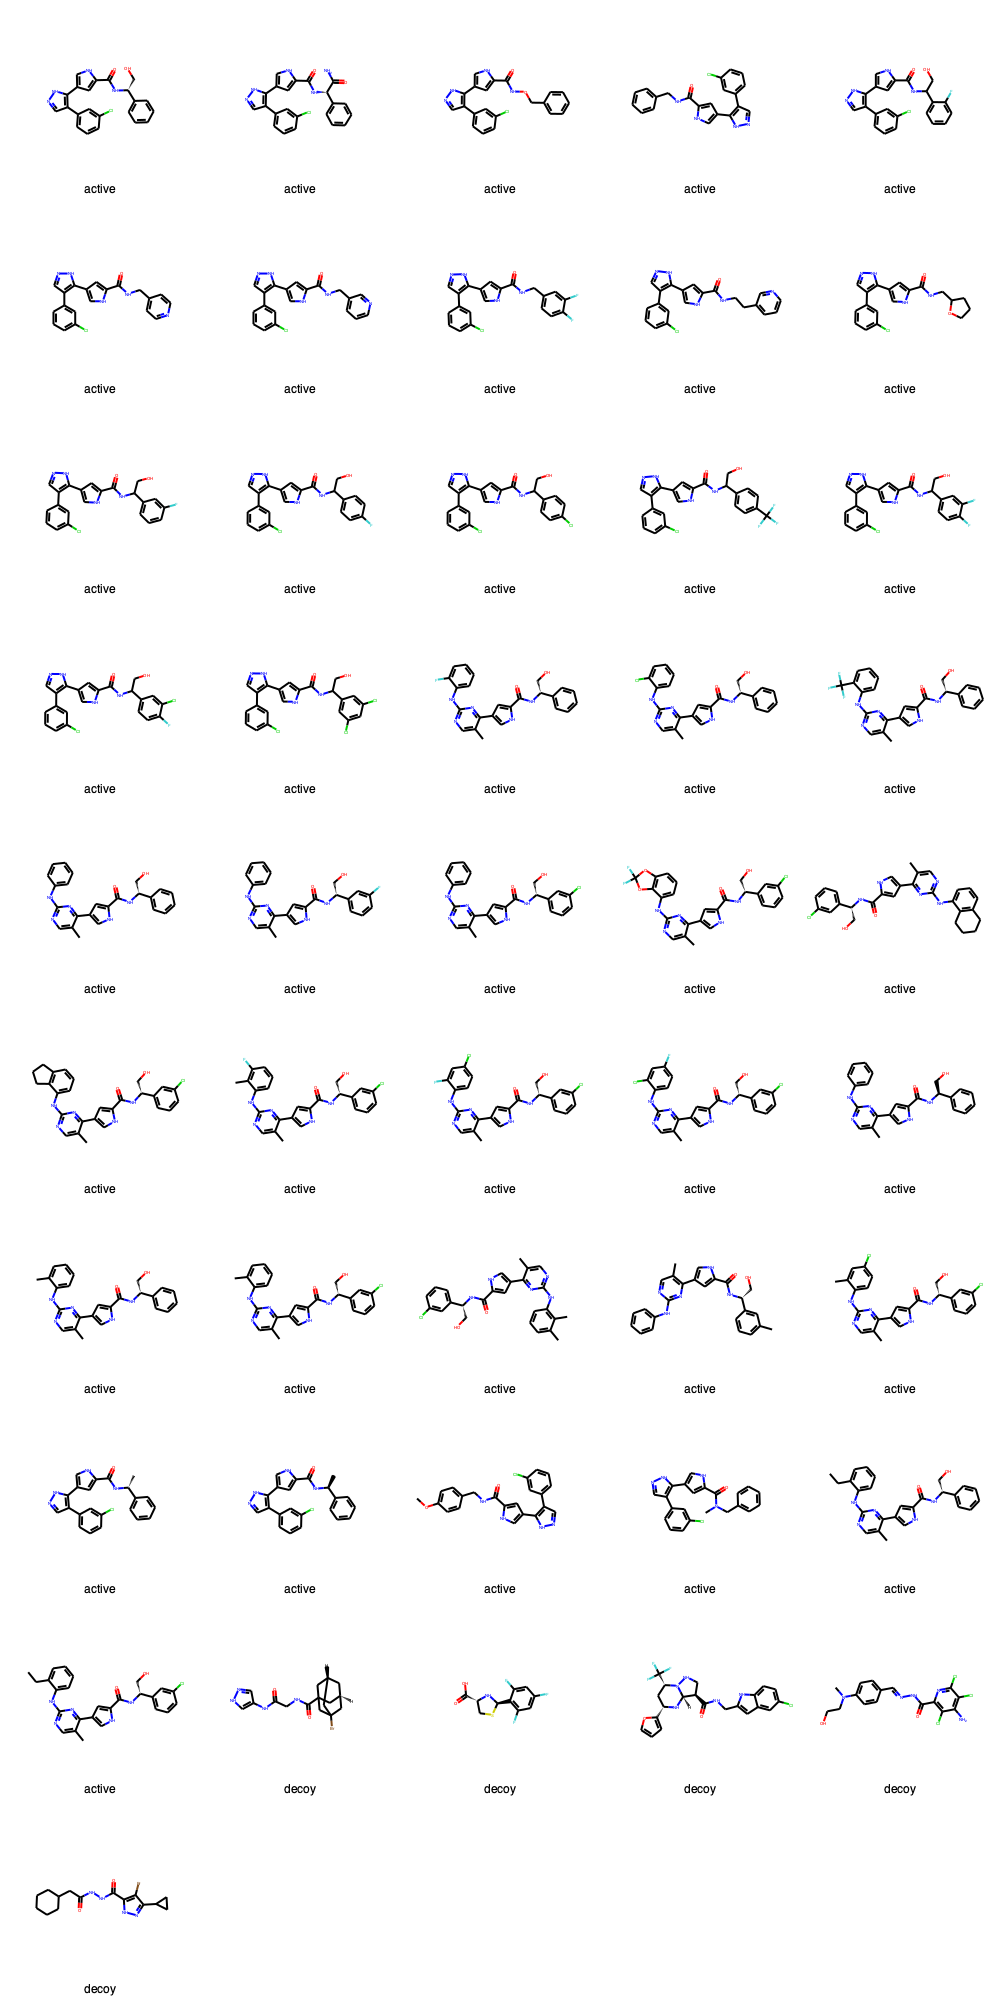

In [12]:
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in my_smiles_list],molsPerRow=5,legends=active_label_list)

A quick look at the figure above indicates that the figure above shows that the active compounds are indeed very similar.  The small number of decoy compounds in the same cell are somewhat similar to the actives but are clearly different chemotypes. 

Generating Fingerprints: 100%|██████████| 4629/4629 [00:01<00:00, 2352.14it/s]


Training SOM
Finding BMUs
Done
Elapsed time = 26.29 sec


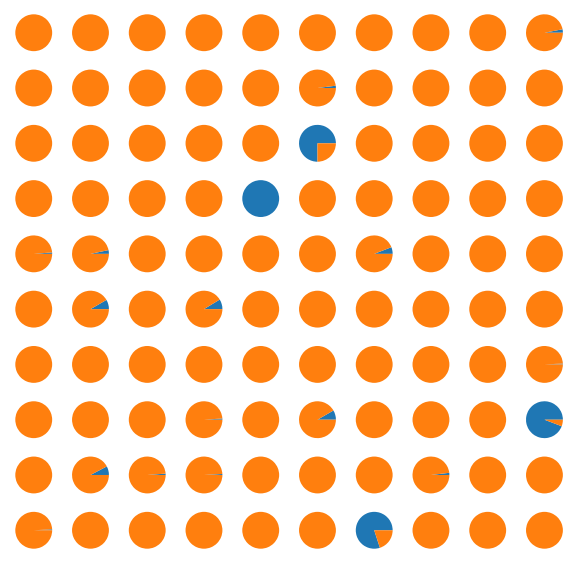

In [13]:
morgan_list = generate_fps(act_df.SMILES,morgan_as_np)
x_dim = 10
y_dim = 10
morgan_x, morgan_y = build_minisom_som(morgan_list, x_dim, y_dim)
act_df["morgan_X"] = morgan_x
act_df["morgan_Y"] = morgan_y
depict_som(act_df, x_dim, y_dim, x_column="morgan_X",y_column="morgan_Y")